# Training Vanilla GAN on CIFAR-10

In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
!pip install torch-summary
from torchsummary import summary
from torchvision.utils import save_image

import gitpath
HOME_PATH = gitpath.root()
sys.path.append(HOME_PATH)

from models.DCGAN import *

In [2]:
class HyperParams:
    def __init__(self):
        # Constance hyperparameters. They have been tested and don't need to be tuned.
        self.n_epochs = 50
        self.batch_size = 64
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_workers = 8
        self.latent_dim = 100
        self.img_size = 32
        self.channels = 3
        self.sample_interval = 500
        self.imgsave_path = os.path.join(HOME_PATH, 'images', 'dcgan')
        self.CHECKPOINT_FOLDER = os.path.join(HOME_PATH, 'saved_model', 'dcgan')
        
params = HyperParams()
os.makedirs(params.imgsave_path, exist_ok=True)
os.makedirs(params.CHECKPOINT_FOLDER, exist_ok=True)

## Step 1: Set up preprocessing functions

In [3]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
        ])

In [4]:
# do NOT change these
import torchvision.datasets as dset
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = os.path.join(HOME_PATH, "data")

# construct dataset
dataset = dset.CIFAR10(
    root=DATA_ROOT,
    train=True,
    download=True,
    transform=transform 
)

# construct dataloader
dataloader = DataLoader(
    dataset, 
    batch_size=params.batch_size,  # your code
    shuffle=True,     # your code
    num_workers=params.n_workers
)

Files already downloaded and verified


## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.

In [5]:
# specify the device for computation

# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition  
generator = Generator(params.latent_dim).to(device)
discriminator = Discriminator().to(device)

# Check if on GPU
assert(next(generator.parameters()).is_cuda)
assert(next(discriminator.parameters()).is_cuda)

Run on GPU...


## Step 4: Set up the loss function and optimizer

In [6]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters according to ResNet paper section 4.2

# create loss function
criterion = nn.BCELoss().to(device)

# Add optimizer
optimizerG = optim.Adam(generator.parameters(), lr=params.lr, betas=(params.b1, params.b2))
optimizerD = optim.Adam(discriminator.parameters(), lr=params.lr, betas=(params.b1, params.b2))

## Step 5: Start the training process.


In [7]:
# some hyperparameters
# total number of training epochs
start_epoch = 0

# start the training/validation process
best_loss_g = 1e20
best_loss_d = 1e20

start = time.time()
print("==> Training starts!")
print("="*50)

# store loss learning curve
g_loss_lst = []
d_loss_lst = []
g_grad_lst = []
d_grad_lst = []

fixed_random_z = torch.randn(params.batch_size, params.latent_dim).to(device)

for i in range(start_epoch, params.n_epochs):
    epoch_start = time.time()
    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    g_loss = []
    d_loss = []
    g_grad = []
    d_grad = []
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        
        inputs = inputs.float().to(device)
        batch_size = inputs.size(0)
        
        real_labels = torch.full((batch_size,1), 1.0).to(device)
        fake_labels = torch.full((batch_size,1), 0.0).to(device)
        
        ####################################
        # Train Generator
        ###################################
        # maximize generator's ability to fool discriminator
        z = torch.randn(batch_size, params.latent_dim).to(device)
        gen_imgs = generator(z)
        fake_outputs = discriminator(gen_imgs)
        loss_G = criterion(fake_outputs, real_labels)
        
        # zero the gradient
        optimizerG.zero_grad()
        # backpropagation
        loss_G.backward()
        # record gradients
        if (batch_idx % 1000 == 0):
            gradients_G = []
            for p in generator.parameters():
                gradients_G.extend(p.grad.flatten().cpu().detach().numpy())
            gradients_G = np.linalg.norm(np.asarray(gradients_G).flatten())
            g_grad.append(gradients_G)
        # apply gradient and update the weights
        optimizerG.step()

        # calculate percentage of confidence
        G_z = fake_outputs.mean().item()
        g_loss.append(loss_G.cpu().detach().numpy())
        ####################################
        
        ####################################
        # Train Discriminator
        ###################################
        # train to recog real image
        real_outputs = discriminator(inputs)
        loss_real = criterion(real_outputs, real_labels)
        
        ###################################
        # train to recog fake image
        fake_outputs = discriminator(gen_imgs.detach())
        loss_fake = criterion(fake_outputs, fake_labels)
        
        # sum loss
        loss_D = (loss_fake + loss_real) / 2
        # zero the gradient
        optimizerD.zero_grad()
        # backpropagation
        loss_D.backward()
        # record gradients
        if (batch_idx % 1000 == 0):
            gradients_D = []
            for p in discriminator.parameters():
                gradients_D.extend(p.grad.flatten().cpu().detach().numpy())
            gradients_D = np.linalg.norm(np.asarray(gradients_D).flatten())
            d_grad.append(gradients_D)
        # apply gradient and update the weights
        optimizerD.step()

        # calculate percentage of confidence
        D_x = real_outputs.mean().item()
        D_z = fake_outputs.mean().item()
        d_loss.append(loss_D.cpu().detach().numpy())
        
        ####################################
        
        if (batch_idx % params.sample_interval == 0): 
            batches_done = i * len(dataloader) + batch_idx
            save_image(generator(fixed_random_z).data[:40], os.path.join(params.imgsave_path, "%d.png" % batches_done), nrow=5, normalize=True)
            print("D(x): %.4f D(G(z)): %.4f / %.4f"%(D_x, D_z, G_z))
        
    avg_loss_g = np.sum(np.asarray(g_loss)) / len(g_loss)
    avg_loss_d = np.sum(np.asarray(d_loss)) / len(d_loss)
    avg_grad_g = np.sum(np.asarray(g_grad)) / len(g_grad)
    avg_grad_d = np.sum(np.asarray(d_grad)) / len(d_grad)
    print("Generator loss: %.4f, Generator grad norm: %.4f, Discriminator loss: %.4f, Discriminator grad norm: %.4f"%(avg_loss_g, avg_grad_g, avg_loss_d, avg_grad_d))
    
    g_loss_lst.append(avg_loss_g)
    d_loss_lst.append(avg_loss_d)
    g_grad_lst.append(avg_grad_g)
    d_grad_lst.append(avg_grad_d)
    
    # save the model checkpoint
    state_G = generator.state_dict()
    torch.save(state_G, os.path.join(params.CHECKPOINT_FOLDER, 'generator.pth'))
    state_D = discriminator.state_dict()
    torch.save(state_D, os.path.join(params.CHECKPOINT_FOLDER, 'discriminator.pth'))
    print(f"Epoch finished in {time.time() - epoch_start:.2f}s")
    print("")

print("="*50)
print(f"==> Optimization finished in {time.time() - start:.2f}s!")

==> Training starts!
Epoch 0:
D(x): 0.5829 D(G(z)): 0.5662 / 0.5662
D(x): 0.8943 D(G(z)): 0.0656 / 0.0656
Generator loss: 2.8794, Generator grad norm: 6.0939, Discriminator loss: 0.1700, Discriminator grad norm: 4.6934
Epoch finished in 33.22s

Epoch 1:
D(x): 0.8266 D(G(z)): 0.0932 / 0.0932
D(x): 0.9557 D(G(z)): 0.1810 / 0.1810
Generator loss: 2.6597, Generator grad norm: 35.7332, Discriminator loss: 0.2080, Discriminator grad norm: 3.9901
Epoch finished in 26.35s

Epoch 2:
D(x): 0.9505 D(G(z)): 0.2471 / 0.2471
D(x): 0.9497 D(G(z)): 0.1972 / 0.1972
Generator loss: 3.1100, Generator grad norm: 102.4097, Discriminator loss: 0.1507, Discriminator grad norm: 12.0489
Epoch finished in 25.62s

Epoch 3:
D(x): 0.9706 D(G(z)): 0.2109 / 0.2109
D(x): 0.9272 D(G(z)): 0.0902 / 0.0902
Generator loss: 3.2953, Generator grad norm: 35.1107, Discriminator loss: 0.1396, Discriminator grad norm: 12.8182
Epoch finished in 25.43s

Epoch 4:
D(x): 0.9950 D(G(z)): 0.5871 / 0.5871
D(x): 0.9588 D(G(z)): 0.2180 /

## Step 5: Linear Interpolation Function

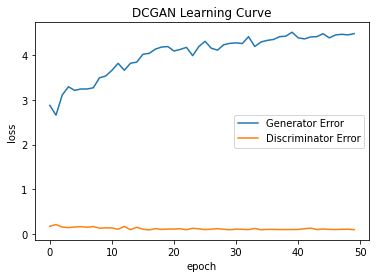

In [10]:
plt.plot(g_loss_lst, label='Generator Error')
plt.plot(d_loss_lst, label='Discriminator Error')
plt.title("DCGAN Learning Curve")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(os.path.join(HOME_PATH, "images","dcgan_lr.png"))

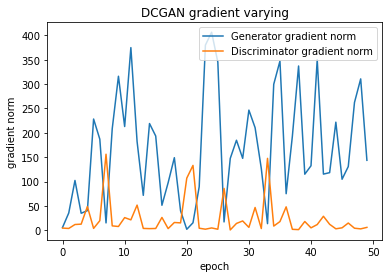

In [12]:
plt.plot(g_grad_lst, label='Generator gradient norm')
plt.plot(d_grad_lst, label='Discriminator gradient norm')
plt.title("DCGAN gradient varying")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('gradient norm')
plt.savefig(os.path.join(HOME_PATH, "images","dcgan_grad.png"))

In [13]:
len(dataloader)

782